# Preliminary Results Ablation Study

## Preparation

In [ ]:
result_path = ""

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pytorch-lightning==1.4.5
!pip install  torchtext==0.6.0
!pip install lmdb
!pip install pytorch-fid
!pip install lpips
!pip install torchmetrics==0.5.0

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from templates_latent import celeba64d2c_autoenc_latent
from templates import celeba64d2c_autoenc, train
import pickle

In [ ]:
gpus = [0]
conf = celeba64d2c_autoenc_latent()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DATA_PATH = ""
MODEL_PATH = ""

In [ ]:
LATENTS_PATH = f"{MODEL_PATH}/latent.pkl"

In [ ]:
BATCH_SIZE = 32

In [ ]:
images = torch.load(f"{DATA_PATH}images.pt")  #load images for interpolation and as basis for manipulation
quadrants = torch.load(f"{DATA_PATH}quadrants.pt") #load corresponding quadrants

In [ ]:
images = images
quadrants = quadrants

In [ ]:
with open(LATENTS_PATH, "rb") as f:  #load the latent representations of all the images by the autoencoder
  latents = torch.load(f)
latents = latents['conds'].numpy()

In [ ]:
quadrant_pair_lis = []
for i in range(4):
  for j in range(i+1, 4):
    quadrant_pair_lis.append((i,j))

In [ ]:
# load results for normal vectors and models to make predictions for quadrants

logreg_dict = {}
normal_vec_dict = {}

for quadrant_pair in quadrant_pair_lis:
  with open(f"{MODEL_PATH}/logreg_model_{quadrant_pair}.pkl", "rb") as f:
    logreg_dict[quadrant_pair] = pickle.load(f)
    normal_vec_dict[quadrant_pair] = np.load(f"{MODEL_PATH}/normal_vector_{quadrant_pair}.npy")
    #normal_vec_dict[quadrant_pair] = logreg_dict[quadrant_pair].coef_

In [ ]:
gpus = [0]
conf = celeba64d2c_autoenc()

In [ ]:
from torch.utils.data import Dataset

class SimpleDataset(Dataset):  #define dataset to match format of DAEs
  def __init__(self, images):
    self.images = images

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = self.images[idx]
    return {'img': img, 'index': idx}

dataset_images = SimpleDataset(images)

In [ ]:
# Define correct config for DAEs

conf.data_name = 'ffhqlmdb256'
conf.make_dataset = lambda: dataset_images
conf.warmup = 0
conf.total_samples = len(images)*100
conf.net_ch_mult = (1, 2, 4, 8)
conf.net_enc_channel_mult = (1, 2, 4, 8, 8)
conf.eval_every_samples = len(images)*10
conf.eval_ema_every_samples = len(images)*10
conf.eval_num_images =  BATCH_SIZE
conf.batch_size = BATCH_SIZE
conf.batch_size_eval = BATCH_SIZE
conf.sample_size = BATCH_SIZE
conf.sample_every_samples = len(images)*10
conf.continue_from = None

In [ ]:
# load trained DAE

from templates import LitModel
model = LitModel(conf)
state = torch.load(f'{MODEL_PATH}/last.ckpt', map_location='cpu')

In [ ]:
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

## Create Synthetic tabular data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_synthetic_table_normal_response(function_list, noise_variance=1, n_datapoints=len(images), x_min=0, x_max=1, equally_spaced=True):
    """
    Create synthetic tabular data with the functions given
    such that the response y is given as y = f_1(x_1) + f_2(x_2) + ... + f_k(x_k) + eps for eps ~ N(0, noise_variance)
    It plots individual graphs for each function in a single row.

    Params:
        function_list: List of functions [f_1, f_2, ..., f_k] to use for the response
        noise_variance: The variance of the added noise
        n_datapoints: Number of samples to generate
        x_min: Minimum x_value for each covariate
        x_max: Maximum x_value for each covariate
        equally_spaced: If True, use equally spaced covariates; otherwise, use random uniform covariates

    Returns:
        X: Matrix containing the training data, has shape n_datapoints x len(function_list)
        y: Response variable, generated as specified
    """
    # Generate covariates (X) based on the specified method
    if equally_spaced:
        X = np.repeat(np.linspace(x_min, x_max, n_datapoints).reshape(-1, 1), len(function_list), axis = 1)
    else:
        X = np.random.uniform(x_min, x_max, size=(n_datapoints, len(function_list)))

    # Initialize an array to store the response variable
    num_functions = len(function_list)
    Y = np.zeros((num_functions, n_datapoints))

    # Create subplots for each function



    # Generate response variable y based on the given functions and noise
    for i, func in enumerate(function_list):
        Y[i] = func(X[:, i])

    # zero-center the effects
    Y = Y - np.mean(Y, axis = 1).reshape(-1, 1)

    noise = np.random.normal(0, np.sqrt(noise_variance), size=n_datapoints)
    if num_functions > 1:
      fig, axs = plt.subplots(1, num_functions, figsize=(15, 5))
      for i, func in enumerate(function_list):
          axs[i].scatter(X[:, i], Y[i] + noise, s=5, label=f'f_{i+1} with noise')
          axs[i].scatter(X[:, i], Y[i], s=5, label=f'f_{i+1}', c = "red")
          axs[i].set_xlabel(f'x_{i+1}')
          axs[i].set_ylabel('y')
          axs[i].legend()

    else:
      fig, axs = plt.subplots(1, num_functions, figsize=(5, 5))
      axs.scatter(X[:, 0], Y[0] + noise, s=5, label=f'f_{1}')
      axs.set_xlabel(f'x_{1}')
      axs.set_ylabel('y')
      axs.legend()

    plt.tight_layout()
    plt.show()

    # Add Gaussian noise with the specified variance
    y_mean = np.sum(Y, axis = 0)



    y = y_mean + noise


    #fig, axs = plt.subplots(1, 2, figsize=(10,5))

    #axs[0].scatter(np.mean(X, axis = 1), y_mean, s=5, label=f'final result without noise')

    #axs[1].scatter(np.mean(X, axis = 1), y, s=5, label=f'final result with noise')
    #axs[1].scatter(np.mean(X, axis = 1), y_mean, s=1, c = "red")

    return X, y, Y, noise


In [ ]:
f1 = lambda x: np.sin(2*np.pi*x) + 3
f2 = lambda x: 2*x
f3 = lambda x: x**4

DATA_FUNCTIONS = [f1, f2, f3]
N_FEATURES_TABULAR = len(DATA_FUNCTIONS)

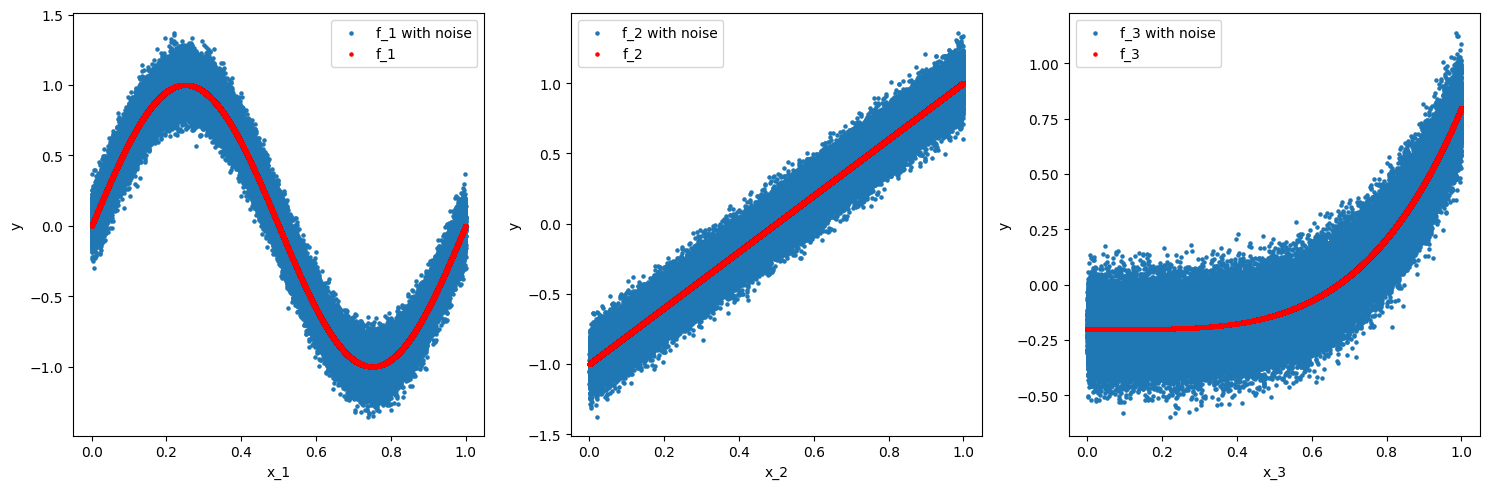

In [ ]:
X_tabular, y_response, Y_response, y_noise = create_synthetic_table_normal_response(DATA_FUNCTIONS, noise_variance = 1e-2, equally_spaced = False)

## Add effect of images to synthetic response

define the effect of the image as follows:
if the white square is in the upper left-hand corner, the effect is "-1", in the upper right-hand corner, it is "1"

In [ ]:
def find_white_square_center(images, threshold=0.5):
    """
    Find the center of mass (centroid) of the white square in each image.

    Args:
        images (torch.Tensor): A batch of images with shape (batch_size, channels, height, width).
        threshold (float): Threshold value to convert images to binary masks (0-1 range).

    Returns:
        torch.Tensor: A tensor containing the (x, y) coordinates of the white square's centroid for each image.
                      The resulting tensor has shape (batch_size, 2).
    """
    batch_size = images.size(0)
    centroids = []

    x_shape, y_shape = images[0, 0].shape
    x_indices = torch.arange(x_shape).float()
    y_indices = torch.arange(y_shape).float()

    for i in range(batch_size):
      image = images[i, 0]
      x_vals_white = torch.sum(image, dim = 0) > threshold
      y_vals_white = torch.sum(image, dim = 1) > threshold

      x_idx_white = torch.mean(x_indices[x_vals_white])
      y_idx_white = torch.mean(y_indices[y_vals_white])

      centroids.append([x_idx_white, y_idx_white])

    return torch.tensor(centroids, dtype=torch.float32)

In [ ]:
centroids = find_white_square_center(images)

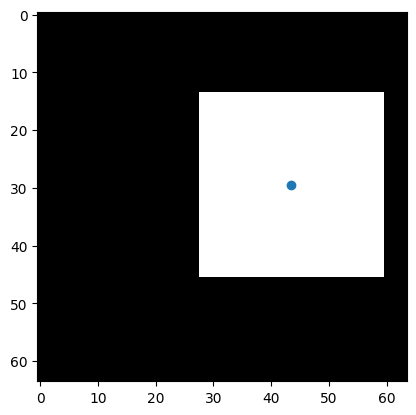

In [ ]:
plt.imshow(images[1].permute(1, 2, 0).cpu())
plt.scatter(centroids[1][0], centroids[1][1])

In [ ]:
centroid_x_values = centroids[:, 0]
min_xvals = torch.min(centroid_x_values)
max_xvals = torch.max(centroid_x_values)

In [ ]:
# use a linear function of how much the image x-position varies between the upper left hand-side corner and the upper right-hand-side corner


standardize_x_vals = lambda x: ((x-min_xvals) / (max_xvals - min_xvals))   #scale position values between 0 and 1


f_img_raw = lambda x: 2*x
f_img = lambda x: f_img_raw(standardize_x_vals(x))

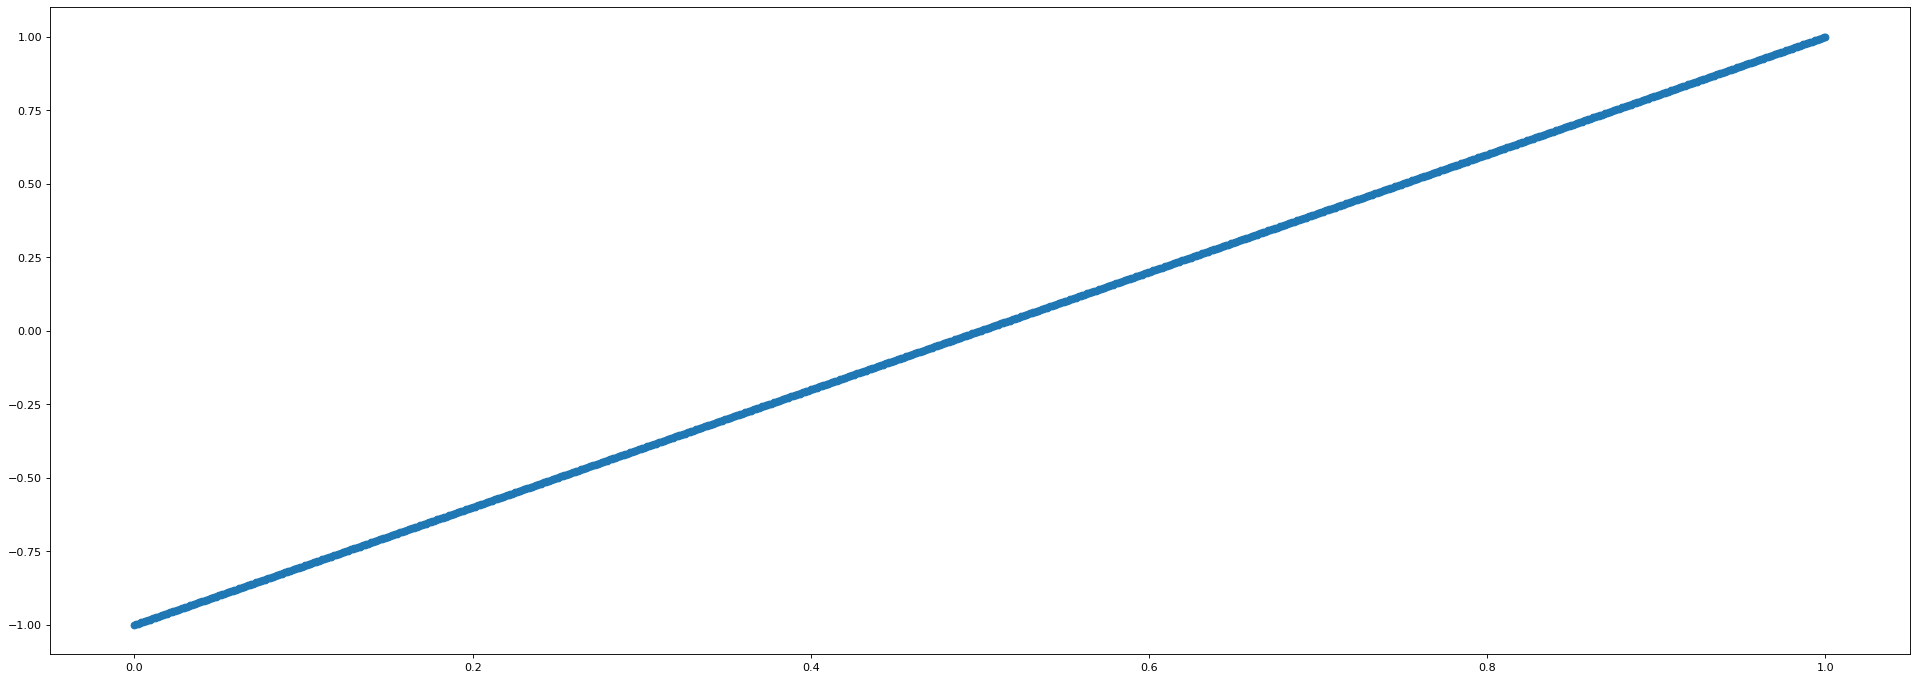

In [ ]:
min_img_x = standardize_x_vals(centroid_x_values).min().numpy()
max_img_x = standardize_x_vals(centroid_x_values).max().numpy()
x_test_img = np.linspace(min_img_x, max_img_x, 1000)

y_test_img = f_img_raw(torch.tensor(x_test_img)).numpy()
y_test_img = y_test_img - np.mean(y_test_img)

from matplotlib.pyplot import figure

figure(figsize=(30, 10.5), dpi=80)

plt.scatter(x_test_img, y_test_img)



In [ ]:
img_effect= f_img(centroid_x_values).numpy()
img_effect = (img_effect - np.mean(img_effect))


In [ ]:
np.mean(img_effect), np.std(img_effect),  np.max(img_effect), np.min(img_effect)

(3.412247e-08, 0.5949485, 0.9960549, -1.0039451)

In [ ]:
y_response = y_response + img_effect

In [ ]:
y_response = (y_response - np.mean(y_response))

## Define NAM

In [ ]:
class FeatureNN(torch.nn.Module):
    def __init__(self,
                 shallow_units: int,   # number of neurons in first layer
                 hidden_units = [],  # tuple of numbers of hidden units
                 activation = torch.nn.ReLU(),
                 dropout: float = .5,
                 ):
        super().__init__()

        # Define Layers
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(shallow_units if i == 0 else hidden_units[i - 1], hidden_units[i])
            for i in range(len(hidden_units))
        ])

        self.layers.insert(0, torch.nn.Linear(1, shallow_units))
        self.output_layer = torch.nn.Linear(hidden_units[-1], 1)

        # Dropout and activation
        self.dropout = torch.nn.Dropout(p=dropout)
        self.activation = activation


    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


class NAM(torch.nn.Module):
  def __init__(self,
                n_features,
                shallow_units: int,   # number of neurons in first layer
                hidden_units = [],  # tuple of numbers of hidden units
                activation = torch.nn.ReLU(),
                dropout: float = .5,
                feature_dropout = 0.0,
                return_output_lis = False
                ):
      super().__init__()

      self.shallow_units = shallow_units
      self.hidden_units = hidden_units
      self.activation = activation
      self.dropout = dropout

      self.n_features = n_features
      self.feature_dropout_rate = feature_dropout
      self.return_output_lis = return_output_lis

      self.feature_nns = torch.nn.ModuleList([
            FeatureNN(shallow_units=shallow_units,
                      hidden_units=hidden_units,
                      activation=activation,
                      dropout=dropout)
            for i in range(n_features)
        ])

      self.bias = torch.nn.Parameter(torch.zeros(1))
      self.feature_dropout = torch.nn.Dropout(p=self.feature_dropout_rate)

  def forward(self, x, f):
    eta = self.bias
    output_lis = []
    for feature, mod in zip(f.T, self.feature_nns):
      feature = feature.unsqueeze(-1)
      ri = mod(feature)
      output_lis.append(ri)

    if self.return_output_lis:
      return output_lis

    else:
       conc_out = torch.cat(output_lis, dim=-1)
       dropout_out = self.feature_dropout(conc_out)
       out = torch.sum(dropout_out, dim=-1) + self.bias

       return out


class NAM_plus_CNN(torch.nn.Module):
  def __init__(self,
                pretrained_encoder,
                mlp,
                feat_nam,
                ):
      super().__init__()

      self.pretrained_encoder = pretrained_encoder
      self.mlp = mlp
      self.feat_nam = feat_nam
      self.feat_nam.return_output_lis = True

  def forward(self, image, features):
    output_lis_nam = self.feat_nam(_, features)

    res_cnn = self.pretrained_encoder.encode(image)
    res_cnn = self.mlp(res_cnn)

    output_lis = output_lis_nam + [res_cnn]
    output_lis = torch.cat(output_lis, dim=-1)


    output_lis = self.feat_nam.feature_dropout(output_lis)
    out = torch.sum(output_lis, dim=-1) + self.feat_nam.bias
    return out

class NAM_plus_MLP(torch.nn.Module):
  """
  class for a NAM that also includes the effect of a an embedding vector
  """
  def __init__(self,
                mlp,
                feat_nam,
                ):
      super().__init__()

      self.mlp = mlp
      self.feat_nam = feat_nam
      self.feat_nam.return_output_lis = True

  def forward(self, features, latent_vec):
    output_lis_nam = self.feat_nam(_, features)

    res_cnn = self.mlp(latent_vec)

    output_lis = output_lis_nam + [res_cnn]
    output_lis = torch.cat(output_lis, dim=-1)


    output_lis = self.feat_nam.feature_dropout(output_lis)
    #print(output_lis)
    out = torch.sum(output_lis, dim=-1) + self.feat_nam.bias
    return out

class One_Layer_MLP(torch.nn.Module):
  def __init__(self,  n_input_units):

    super(One_Layer_MLP, self).__init__()

    self.n_input_units = n_input_units
    self.fc1 = torch.nn.Linear(n_input_units, 1)

  def forward(self, x):

    x = self.fc1(x)
    return x


class Linear_skip_block(nn.Module):
  """
  Block of linear layer + softplus + skip connection +  dropout  + batchnorm
  """
  def __init__(self, n_input, dropout_rate):
    super(Linear_skip_block, self).__init__()

    self.fc = nn.Linear(n_input, n_input)
    self.act = torch.nn.LeakyReLU()

    self.bn = nn.BatchNorm1d(n_input, affine = True)
    self.drop = nn.Dropout(dropout_rate)

  def forward(self, x):
    x0 = x
    x = self.fc(x)
    x = self.act(x)
    x = x0 + x
    x = self.drop(x)
    x = self.bn(x)

    return x

class Linear_block(nn.Module):
  """
  Block of linear layer dropout  + batchnorm
  """
  def __init__(self, n_input, n_output, dropout_rate):
    super(Linear_block, self).__init__()

    self.fc = nn.Linear(n_input, n_output)
    self.act = torch.nn.LeakyReLU()
    self.bn = nn.BatchNorm1d(n_output, affine = True)
    self.drop = nn.Dropout(dropout_rate)

  def forward(self, x):
    x = self.fc(x)
    x = self.act(x)
    x = self.drop(x)
    x = self.bn(x)

    return x

class MLP(nn.Module):
  def __init__(self, n_input_units, n_hidden_units, n_skip_layers, dropout_rate):

    super(MLP, self).__init__()
    self.n_input_units = n_input_units
    self.n_hidden_units = n_hidden_units
    self.n_skip_layers = n_skip_layers
    self.dropout_rate = dropout_rate

    self.linear1 = Linear_block(n_input_units, n_hidden_units, dropout_rate)    # initial linear layer
    self.hidden_layers = torch.nn.Sequential(*[Linear_skip_block(n_hidden_units, dropout_rate) for _ in range(n_skip_layers)])  #hidden skip-layers

    self.linear_final =  torch.nn.Linear(n_hidden_units, 1)

  def forward(self, x):
    x = self.linear1(x)
    x = self.hidden_layers(x)
    x = self.linear_final(x)

    return(x)

class CNN(nn.Module):
  def __init__(self, pretrained_model, mlp):
    super(CNN, self).__init__()

    self.pretrained_model = pretrained_model
    self.pretrained_model.requires_grad = False
    self.mlp = mlp

  def forward(self, x, f):
    with torch.no_grad():
      x = self.pretrained_model.encode(x)
    x = self.mlp(x)

    return x

In [ ]:
def var_exp_score(predictions, targets):
  mean_sum_of_squares = torch.mean((predictions - targets)**2)
  variance_targets = torch.var(targets)
  var_exp = 1- mean_sum_of_squares/variance_targets

  return var_exp

def coef_det(x, y):
  sum_x = torch.sum(x)
  sum_y = torch.sum(y)
  n = len(x)

  numerator = n * torch.sum(x * y) - sum_x*sum_x
  denominator = (n * torch.sum(x**2) - sum_x**2)**0.5 * (n * torch.sum(y**2) - sum_y**2)**0.5

  return numerator/denominator


def mad_explained(predictions, targets):
  mean_sum_of_ad = torch.mean(torch.abs(predictions - targets))
  deviation_median = torch.mean(torch.abs(targets - torch.median(targets)))

  mad_exp = 1 - mean_sum_of_ad/deviation_median

  return mad_exp

In [ ]:
import numpy as np
import time
from tqdm import tqdm
#Validation function

def validate(model, dataloader, loss_fun):
    val_loss_lis = []

    target_lis = []
    pred_lis = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

          x, f, y = batch
          x = x.to(device)
          f = f.to(device)
          y = y.to(device)
          pred = model(x, f)
          pred = pred.squeeze(-1)
          loss = loss_fun(pred, y)
          val_loss_lis.append(loss.cpu().detach())

          target_lis.append(y.detach().cpu())
          pred_lis.append(pred.detach().cpu())

    mean_loss = np.mean(np.array(val_loss_lis))
    median_loss = np.median(np.array(val_loss_lis))

    target_ten, pred_ten = torch.cat(target_lis), torch.cat(pred_lis)
    var_exp = var_exp_score(pred_ten, target_ten)
    mad_exp = mad_explained(pred_ten, target_ten)
    r_score = coef_det(pred_ten, target_ten)
    return mean_loss, median_loss, var_exp, mad_exp, r_score



# Training function
def train_loop(model, optimizer, loss_fun, trainset, valset, print_mod, device, n_epochs, save_path = None, early_stopping = True, n_epochs_early_stopping = 5):
    """
    train the model
    Args:
        model: The model to train
        optimizer: The used optimizer
        loss_fun: The used loss function
        trainset: The dataset to train on
        valset: The dataset to use for validation
        print_mod: Number of epochs to print result after
        device: Either "cpu" or "cuda"
        n_epochs: Number of epochs to train
        save_path: Path to save the model's state dict
        config: config file from the model to train
        sparse_ten (bool): if a sparse tensor is used for each batch
    """
    if early_stopping == True:
      n_early_stopping = n_epochs_early_stopping
      past_val_losses = []

    loss_lis = []
    target_lis = []
    pred_lis = []

    loss_lis_all = []
    val_loss_lis_all = []

    model = model.to(device)

    model.train()
    for epoch in range(n_epochs):
      start = time.time()
      for iter, batch in enumerate(tqdm(trainset)):

        x, f, y = batch
        x = x.to(device)
        f = f.to(device)
        y = y.to(device)
        pred = model(x, f)
        pred = pred.squeeze(-1)


        loss = loss_fun(pred, y)
        #print(loss)

        optimizer.zero_grad()       # clear previous gradients
        loss.backward()             # backprop

        optimizer.step()

        loss_lis.append(loss.cpu().detach())
        target_lis.append(y.detach().cpu())
        pred_lis.append(pred.detach().cpu())

      if epoch % print_mod == 0:

        end = time.time()
        time_delta = end - start

        mean_loss = np.mean(np.array(loss_lis))
        median_loss = np.median(np.array(loss_lis))

        target_ten, pred_ten = torch.cat(target_lis), torch.cat(pred_lis)
        var_exp = var_exp_score(pred_ten, target_ten)
        mad_exp = mad_explained(pred_ten, target_ten)
        r_score = coef_det(pred_ten, target_ten)

        target_lis = []
        pred_lis = []



        loss_lis_all += loss_lis

        loss_lis = []



        mean_loss_val, median_loss_val, var_exp_val, mad_exp_val, val_r_score = validate(model, val_loader, loss_fun = loss_fun)

        val_loss_lis_all.append(mean_loss_val)



        print(f'Epoch nr {epoch}: mean_train_loss = {mean_loss}, median_train_loss = {median_loss}, train_var_exp = {var_exp}, train_mad_exp = {mad_exp}, train_r = {r_score}, elapsed time: {time_delta}')
        print(f'Epoch nr {epoch}: mean_valid_loss = {mean_loss_val}, median_valid_loss = {median_loss_val}, valid_var_exp = {var_exp_val}, valid_mad_exp = {mad_exp_val},  valid_r = {val_r_score}')



        # early stopping based on median validation loss:
        if early_stopping:
          if len(past_val_losses) == 0 or mean_loss_val < min(past_val_losses):
            print("save model")
            torch.save(model.state_dict(), save_path)

          if len(past_val_losses) >= n_early_stopping:
            if mean_loss_val > max(past_val_losses):
              print(f"Early stopping because the median validation loss has not decreased since the last {n_early_stopping} epochs")
              return loss_lis_all, val_loss_lis_all
            else:
              past_val_losses = past_val_losses[1:] + [mean_loss_val]
          else:
            past_val_losses = past_val_losses + [mean_loss_val]



    return loss_lis_all, val_loss_lis_all

### Dataloaders

In [ ]:
class CustomDataset_latents_images(torch.utils.data.Dataset):
    """Create dataloader with features, latent variables, images and labels"""
    def __init__(self, feature_ten, images_ten, latent_ten, label_ten):

        self.images_ten = images_ten
        self.feature_ten = feature_ten
        self.label_ten = label_ten
        self.latent_ten = latent_ten

        assert len(feature_ten) == len(label_ten) ==  len(latent_ten) == len(images_ten), "img_ten and and feature_ten and label ten and latent_ten must have equal size"
    def __len__(self):
      return len(self.images_ten)

    def __getitem__(self, idx):
      img = self.images_ten[idx]
      tab_features = self.feature_ten[idx]
      latents = self.latent_ten[idx]
      y = self.label_ten[idx]

      return img, tab_features, latents, y


class CustomDataset_latents(torch.utils.data.Dataset):
    """Create dataloader with features, latent variables and labels"""
    def __init__(self, feature_ten, latent_ten, label_ten):

        self.feature_ten = feature_ten
        self.label_ten = label_ten
        self.latent_ten = latent_ten

        assert len(feature_ten) == len(label_ten) ==  len(latent_ten), "feature_ten and label ten and latent_ten must have equal size"
    def __len__(self):
      return len(self.feature_ten)

    def __getitem__(self, idx):
      tab_features = self.feature_ten[idx]
      latents = self.latent_ten[idx]
      y = self.label_ten[idx]

      return tab_features, latents, y

In [ ]:
def train_test_split_features_images_latents(features, images, latents, targets, train_frac, val_frac, batch_size):

    # Create an index vector for shuffling
    num_samples = len(features)
    index_vector = torch.randperm(num_samples)

    # Shuffle all four tensors using the index vector
    features = features[index_vector]
    images = images[index_vector]
    latents = latents[index_vector]
    targets = targets[index_vector]

    tot_len = len(features)

    train_max_idx = int(tot_len*train_frac)
    val_max_idx = int(tot_len*val_frac) + train_max_idx

    train_features = features[:train_max_idx]
    train_images = images[:train_max_idx]
    train_latents = latents[:train_max_idx]
    train_y = targets[:train_max_idx]

    val_features = features[train_max_idx:val_max_idx]
    val_images = images[train_max_idx:val_max_idx]
    val_latents = latents[train_max_idx:val_max_idx]
    val_y = targets[train_max_idx:val_max_idx]

    test_features = features[val_max_idx:]
    test_images = images[val_max_idx:]
    test_latents = latents[val_max_idx:]
    test_y = targets[val_max_idx:]

    train_set = CustomDataset_latents_images(train_features, train_images, train_latents, train_y)
    val_set = CustomDataset_latents_images(val_features, val_images, val_latents, val_y)
    test_set = CustomDataset_latents_images(test_features, test_images, test_latents, test_y)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

def train_test_split_features_latents(features, latents, targets, train_frac, val_frac, batch_size):
    tot_len = len(features)

    # Create an index vector for shuffling
    num_samples = len(features)
    index_vector = torch.randperm(num_samples)

    # Shuffle all three tensors using the index vector
    features = features[index_vector]
    latents = latents[index_vector]
    targets = targets[index_vector]

    train_max_idx = int(tot_len*train_frac)
    val_max_idx = int(tot_len*val_frac) + train_max_idx

    train_features = features[:train_max_idx]
    train_latents = latents[:train_max_idx]
    train_y = targets[:train_max_idx]

    val_features = features[train_max_idx:val_max_idx]
    val_latents = latents[train_max_idx:val_max_idx]
    val_y = targets[train_max_idx:val_max_idx]

    test_features = features[val_max_idx:]
    test_latents = latents[val_max_idx:]
    test_y = targets[val_max_idx:]

    train_set = CustomDataset_latents(train_features, train_latents, train_y)
    val_set = CustomDataset_latents(val_features, val_latents, val_y)
    test_set = CustomDataset_latents(test_features, test_latents, test_y)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = train_test_split_features_latents(
    features = torch.tensor(X_tabular).float(),
    latents = latents,
    targets = torch.tensor(y_response).float(),
    train_frac = 0.7,
    val_frac = 0.2,
    batch_size = 128)   # create dataloader with embeddings

### Train model

#### Train NAM without image effect

In [ ]:
pure_nam_save_path = ""


#model_cnn = CNN(
#    pretrained_model = pretrained_encoder,
#    mlp = mlp

#)

"""
nam = NAM(n_features=N_FEATURES_TABULAR,
                            shallow_units=20,
                            hidden_units=(100, 100, 100),
                            activation= torch.nn.ReLU(),
                            dropout=0.5,
                            feature_dropout = 0.5
          )
"""
pure_nam = NAM(n_features=N_FEATURES_TABULAR,
                            shallow_units=100,
                            hidden_units=(100, 100, 100),
                            activation= torch.nn.ReLU(),
                            dropout=0.2,
                            feature_dropout = 0.5)

In [ ]:
lr = 1e-3
opt = torch.optim.AdamW(pure_nam.parameters(), lr = lr, weight_decay=1e-3)

In [ ]:
r1 = train_loop(model = pure_nam,
           optimizer = opt,
           loss_fun = torch.nn.MSELoss(),     #torch.nn.L1Loss4
           trainset = train_loader,
           valset = val_loader,
           print_mod = 1,
           device = device,
           early_stopping = True,
           n_epochs_early_stopping = 5,
           save_path = pure_nam_save_path,
           n_epochs = 10000)

In [ ]:
pure_nam.load_state_dict(torch.load(pure_nam_save_path))

In [ ]:
validate(pure_nam, test_loader, torch.nn.MSELoss())

In [ ]:
pure_nam = pure_nam.eval().to(device)

### Train NAM with image effect

In [ ]:
save_path = ""

mlp = MLP(n_input_units = latents.shape[1],
    n_hidden_units = 100,
    n_skip_layers =4,
    dropout_rate = 0.2)

#model_cnn = CNN(
#    pretrained_model = pretrained_encoder,
#    mlp = mlp

#)

"""
nam = NAM(n_features=N_FEATURES_TABULAR,
                            shallow_units=20,
                            hidden_units=(100, 100, 100),
                            activation= torch.nn.ReLU(),
                            dropout=0.5,
                            feature_dropout = 0.5
          )
"""
nam = NAM(n_features=N_FEATURES_TABULAR,
                            shallow_units=100,
                            hidden_units=(100, 100, 100),
                            activation= torch.nn.ReLU(),
                            dropout=0.2,
                            feature_dropout = 0.5
          )

cnam = NAM_plus_MLP(mlp, nam)

In [ ]:
lr = 1e-3
opt = torch.optim.AdamW(cnam.parameters(), lr = lr, weight_decay=1e-2)
#opt = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay=1e-3)

In [ ]:

r2 = train_loop(model = cnam,
           optimizer = opt,
           loss_fun = torch.nn.MSELoss(),     #torch.nn.L1Loss4
           trainset = train_loader,
           valset = val_loader,
           print_mod = 1,
           device = device,
           early_stopping = True,
           n_epochs_early_stopping = 5,
           save_path = save_path,
           n_epochs = 10000)

In [ ]:
cnam.load_state_dict(torch.load(save_path))

In [ ]:
cnam = cnam.eval().to(device)

In [ ]:
validate(cnam, test_loader, torch.nn.MSELoss())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

def plot_feature_nn(feature_nn, x_vals_compute, bias, x_vals_to_plot, ax=None, y_data=None, unscale_fun=None, q = 0, y_gt = None):


    with sns.axes_style('whitegrid'):
      with sns.color_palette('dark'):

        max_fun = lambda x: np.quantile(x, q = 1-q)
        min_fun = lambda x: np.quantile(x, q = q)

        valid_idx = (x_vals_compute >= min_fun(x_vals_compute)) & (x_vals_compute <= max_fun(x_vals_compute))

        x_vals_compute = x_vals_compute[valid_idx]
        x_vals_to_plot = x_vals_to_plot[valid_idx]

        #if y_data is not None:
        #  y_data = y_data[valid_idx]




        min_compute = min(x_vals_compute)
        max_compute = max(x_vals_compute)
        range_compute = np.linspace(min_compute, max_compute, 10000)

        min_plot = min(x_vals_to_plot)
        max_plot = max(x_vals_to_plot)
        range_plot = np.linspace(min_plot, max_plot, 10000)

        feature_nn = feature_nn.eval()
        with torch.no_grad():
            model_input = torch.tensor(range_compute).to(device).reshape(-1, 1).float()
            y_pred = feature_nn(model_input) + bias

            if not unscale_fun is None:
                y_pred = unscale_fun(y_pred)


            if ax is None:
                fig, ax = plt.subplots(figsize=(10, 10))
            else:
                fig = plt.gcf()

            fig.set_size_inches(30/2, 10.5/2)
            # Plot the model prediction

            if y_gt is not None:
              sns.lineplot(x = x_vals_to_plot, y = y_gt,  color="green", linewidth=2, label="Reference")

            sns.lineplot(x=range_plot, y=y_pred.squeeze().cpu().numpy(), color="r", label="Model Prediction", linewidth=2)


            print(x_vals_to_plot.shape)
            y_pred_data = feature_nn(torch.tensor(x_vals_to_plot).to(device).float().unsqueeze(1)) + bias

            var_exp = var_exp_score(y_pred_data.squeeze().cpu(), torch.tensor(y_gt))
            mad_exp = mad_explained(y_pred_data.squeeze().cpu(), torch.tensor(y_gt))
            r_score = coef_det(y_pred_data.squeeze().cpu(), torch.tensor(y_gt))

            mse = torch.nn.MSELoss()(y_pred_data.squeeze().cpu(), torch.tensor(y_gt))

            print( {
                "var_exp": var_exp.item(),
                "mad_exp": mad_exp.item(),
                "r_score": r_score.item(),
                "mse": mse.item()
            })

            # Plot the training data
            if y_data is not None:
                sns.scatterplot(x=x_vals_to_plot, y=y_data, color="blue", alpha=0.5, s = 2, label="Test Data", ax=ax)



            # Customize the plot
            ax.set_xlabel("X", fontsize=15)
            ax.set_ylabel("Y", fontsize=15)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_linewidth(1.5)
            ax.spines["left"].set_linewidth(1.5)
            ax.tick_params(axis='both', which='major', labelsize=15, width=1.5)
            #ax.set_xticks(fontsize=15)

            # Add a title and legend
            #ax.set_title("Feature Neural Network", fontsize=20)
            ax.legend(fontsize=20, frameon=True,markerscale = 2)

            # Add a grid
            ax.grid(True, alpha=0.3)

            plt.tight_layout()

            return fig, ax



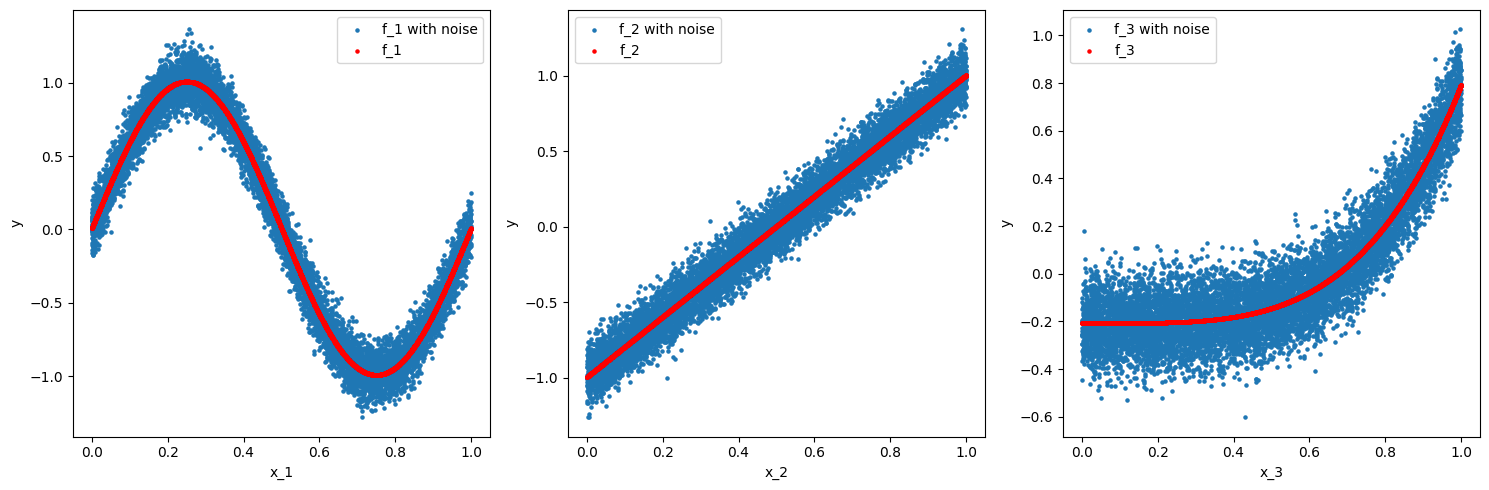

In [ ]:
X_tabular_test, y_response_test, Y_response_test, y_noise_test = create_synthetic_table_normal_response(DATA_FUNCTIONS, noise_variance = 1e-2, n_datapoints = 10000, equally_spaced = False)

## Interpolation

Interpolate between images $i_1$ and $i_2$ by encoding both with the semantic and stochastic encoder, followed by interpolation between the encodings where simple linear interpolation is used for the semantic encoder and shperical linear interpolation for the stochastic subcode. The images on the "latent interpolation path" are then decoded.

### Visalize how the effects would look like based on the simulated data

In [ ]:
def find_centroid_torch(img):
    # Convert the image to a binary mask where white pixels are True
    binary_mask = torch.all(img >= 0.8, dim=2)

    # Find the coordinates of the white pixels
    y_coords, x_coords = torch.where(binary_mask)

    # Calculate the centroid
    centroid_x = torch.mean(x_coords.float())
    centroid_y = torch.mean(y_coords.float())

    return int(centroid_x.item()), int(centroid_y.item())


In [ ]:
def generate_img(centroid_position, size=64):
    # Create a black image of the specified size
    img = torch.zeros((size, size, 3), dtype = torch.float)

    # Calculate the top left position of the square
    square_size = 32
    top_left_x = centroid_position[0] - square_size // 2
    top_left_y = centroid_position[1] - square_size // 2

    # Ensure the square doesn't go out of the image boundaries
    top_left_x = max(0, min(size - square_size, top_left_x))
    top_left_y = max(0, min(size - square_size, top_left_y))

    # Draw a white square on the black image
    img[top_left_y:top_left_y + square_size, top_left_x:top_left_x + square_size] = 1

    return img

# Example usage
centroid = (32, 32)  # Center of the image
img = generate_img(centroid)
print(find_centroid_torch(img))

# Display the image
plt.imshow(img)
plt.show()


In [ ]:
def interpolate_positions(pos1, pos2, n_steps):
    """
    Linearly interpolate between two positions.
    """
    x1, y1 = pos1
    x2, y2 = pos2

    x_values = torch.linspace(x1, x2 + 1, n_steps)
    y_values = torch.linspace(y1, y2 +1 , n_steps)

    return zip(x_values, y_values)


def visualize_original_image_effects(img1, img2, n_steps_images):
    """
    Generate a sequence of images interpolating between img1 and img2 based on the centroid's positions.
    Args:
      img1: first image
      img2: second image
    """

    # Find centroids of the two images
    centroid1 = find_centroid_torch(img1)
    centroid2 = find_centroid_torch(img2)

    # Generate interpolated positions
    interpolated_positions = interpolate_positions(centroid1, centroid2, n_steps_images)

    # Generate and store interpolated images
    interpolated_images = []
    for position in interpolated_positions:
        interpolated_img = generate_img((int(position[0].item()), int(position[1].item())))
        interpolated_images.append(interpolated_img)


    return interpolated_images, interpolated_positions



## Load data with squares directly in the corners

In [ ]:
DATA_PATH_corners = ""

In [ ]:
images_corner = torch.load(f"{DATA_PATH_corners}images.pt")  #load images for interpolation and as basis for manipulation
quadrants_corner = torch.load(f"{DATA_PATH_corners}quadrants.pt") #load corresponding quadrants

In [ ]:
import seaborn as sns

In [ ]:
def plot_images_and_predictions(images, image_preds, preds_smooth, ymin = -1.3, ymax = 1.3):
  """
  Plot the effect of the images
  params:
  images: images to plot
  image_preds: predictions based on images to plot
  preds_smooth: predictions between image_preds to plot
  """
  if image_preds is not None:
    assert len(images) == len(image_preds), "length of images must be equal to length of image_preds"

  with sns.axes_style('darkgrid'):
          with sns.color_palette('dark'):
            fig = plt.figure(figsize=(30, 10.5))
            gs = fig.add_gridspec(2, len(images), height_ratios=[1, 1])

            ax3 = fig.add_subplot(gs[0, :])

            ax3.set_ylim([ymin, ymax])
            if image_preds is not None:
              ax3.plot(range(len(image_preds)), image_preds,'o', markersize=20, c = "blue",linewidth=3)

            x_range_plot_smooth_preds = np.linspace(0, len(images) -1, len(preds_smooth))
            ax3.plot(x_range_plot_smooth_preds, preds_smooth, '-', markersize=10, c = "blue")

            ax3.set_ylabel('Predicted Probability')
            yticks = ax3.get_yticks()


            ax3.set_xticks([]) # remove x_ticks

            # Plot the images
            for i in range(len(images)):
                axi = fig.add_subplot(gs[1, i])
                axi.imshow(images[i].permute(1, 2, 0).cpu())
                axi.xaxis.set_ticklabels([])
                axi.yaxis.set_ticklabels([])

                axi.grid(False)
                axi.set_xlabel(i + 1, fontsize = 20)


            plt.tight_layout()

            plt.show()



In [ ]:
from templates import *

def interpolate_quadrants(q1, q2, prediction_model, images = images, T_encoding = 2, T_decoding = 200, n_datapoints = 1000, n_images = 10):
  """
  Interpolates between images where the white square is in quadrant q1 and quadrant q2.
  params:
    q1: quadrant for first image
    q2: quadrant for last image
    T_encoding: number of steps for the stochastic encoder
    T_decoding: number of steps for the stochastic decoder
  """

  img1 = images_corner[:999][quadrants_corner[:999] == q1][0]
  img2 = images_corner[:999][quadrants_corner[:999] == q2][0]

  batch = torch.stack([
    img1,
    img2,
  ])

  cond = model.encode(batch.to(device))
  xT = model.encode_stochastic(batch.to(device), cond, T=T_encoding)

  alpha = torch.tensor(np.linspace(0, 1, n_images, dtype=np.float32)).to(cond.device)
  intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

  def cos(a, b):
      a = a.view(-1)
      b = b.view(-1)
      a = F.normalize(a, dim=0)
      b = F.normalize(b, dim=0)
      return (a * b).sum()

  theta = torch.arccos(cos(xT[0], xT[1]))
  x_shape = xT[0].shape
  intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
  intp_x = intp_x.view(-1, *x_shape)

  images = model.render(intp_x, intp, T=T_decoding)


  preds_images = prediction_model(intp)[:, 0].detach().cpu().numpy()
  #preds_images = preds_images - np.mean(preds_images)


  alpha_detailed = torch.tensor(np.linspace(0, 1, n_datapoints, dtype=np.float32)).to(cond.device)
  intp_detailed = cond[0][None] * (1 - alpha_detailed[:, None]) + cond[1][None] * alpha_detailed[:, None]

  preds_detailed = prediction_model(intp)[:, 0].detach().cpu().numpy()

  mean = np.mean(preds_detailed)

  preds_detailed = preds_detailed - mean
  preds_images = preds_images - mean

  #plot_images_and_predictions(images, preds_images,preds_detailed)

  return images, preds_images,preds_detailed


def interpolate_images(img1, img2, prediction_model, images = images, T_encoding = 2, T_decoding = 200, n_datapoints = 1000, n_images = 10):
  """
  Interpolates between images where the white square is in quadrant q1 and quadrant q2.
  params:
    img1: first image
    img2: second image
    T_encoding: number of steps for the stochastic encoder
    T_decoding: number of steps for the stochastic decoder
  """

  batch = torch.stack([
    img1,
    img2,
  ])

  cond = model.encode(batch.to(device))
  xT = model.encode_stochastic(batch.to(device), cond, T=T_encoding)

  alpha = torch.tensor(np.linspace(0, 1, n_images, dtype=np.float32)).to(cond.device)
  intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

  def cos(a, b):
      a = a.view(-1)
      b = b.view(-1)
      a = F.normalize(a, dim=0)
      b = F.normalize(b, dim=0)
      return (a * b).sum()

  theta = torch.arccos(cos(xT[0], xT[1]))
  x_shape = xT[0].shape
  intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
  intp_x = intp_x.view(-1, *x_shape)

  images = model.render(intp_x, intp, T=T_decoding)


  preds_images = prediction_model(intp)[:, 0].detach().cpu().numpy()
  #preds_images = preds_images - np.mean(preds_images)


  alpha_detailed = torch.tensor(np.linspace(0, 1, n_datapoints, dtype=np.float32)).to(cond.device)
  intp_detailed = cond[0][None] * (1 - alpha_detailed[:, None]) + cond[1][None] * alpha_detailed[:, None]

  preds_detailed = prediction_model(intp_detailed)[:, 0].detach().cpu().numpy()

  mean = np.mean(preds_detailed)

  preds_detailed = preds_detailed - mean
  preds_images = preds_images - mean

  #plot_images_and_predictions(images, preds_images,preds_detailed)

  return images, preds_images,preds_detailed


In [ ]:
def interpolate_quadrants_gt(q1, q2, feature_extraction_fun = find_centroid_torch, prediction_fun = f_img_raw, images = images, n_datapoints = 1000, n_images= 10):
  img1 = images_corner[:999][quadrants_corner[:999] == q1][0].permute((1, 2, 0))
  img2 = images_corner[:999][quadrants_corner[:999] == q2][0].permute((1, 2, 0))

  interpolated_images, _ = visualize_original_image_effects(img1, img2, n_images)
  interpolated_images = [img/2 +0.5 for img in interpolated_images]

  latent_1 = feature_extraction_fun(img1)[0]
  latent_2 = feature_extraction_fun(img2)[0]
  if latent_1 == latent_2:
    latent_intp = np.zeros((n_images))
  else:
    latent_intp = np.linspace(latent_1, latent_2 +1, n_images)
    latent_intp = (latent_intp - np.min(latent_intp))/(np.max(latent_intp) - np.min(latent_intp))

  preds_smooth = np.array([prediction_fun(latent_i).item() for latent_i in latent_intp])


  #preds_smooth = preds_smooth - np.mean(preds_smooth)
  preds_images = preds_smooth

  mean = np.mean(preds_smooth)
  preds_smooth = preds_smooth - mean
  preds_images = preds_images -mean

  interpolated_images = [img.permute((2, 0, 1)) for img in interpolated_images]


  #plot_images_and_predictions(interpolated_images, image_preds = preds_images, preds_smooth = preds_smooth)

  return interpolated_images, preds_images, preds_smooth


In [ ]:
def interpolate_images_gt(img1, img2, feature_extraction_fun = find_centroid_torch, prediction_fun = f_img_raw, images = images, n_datapoints = 1000, n_images= 10):
  if img1.shape[-1] != 3:
    img1 = img1.permute(1, 2, 0)
    img2 = img2.permute(1,2,0)

  interpolated_images, _ = visualize_original_image_effects(img1, img2, n_images)
  interpolated_images = [img/2 +0.5 for img in interpolated_images]

  latent_1 = standardize_x_vals(feature_extraction_fun(img1)[0])
  latent_2 = standardize_x_vals(feature_extraction_fun(img2)[0])

  latent_intp = np.linspace(latent_1, latent_2, n_datapoints)
  #latent_intp = (latent_intp - np.min(latent_intp))/(np.max(latent_intp) - np.min(latent_intp))

  preds_smooth = np.array([prediction_fun(latent_i).item() for latent_i in latent_intp])

  interval = n_datapoints // (n_images - 1)

  # Generate the indices of the selected points
  selected_indices = [i * interval for i in range(n_images - 1)] + [n_datapoints - 1]

  preds_images = preds_smooth[selected_indices]

  mean = np.mean(preds_smooth)
  preds_smooth = preds_smooth - mean
  preds_images = preds_images -mean

  interpolated_images = [img.permute((2, 0, 1)) for img in interpolated_images]

  #plot_images_and_predictions(interpolated_images, image_preds = preds_images, preds_smooth = preds_smooth)

  return interpolated_images, preds_images, preds_smooth

In [ ]:
def interpolate_images_gt_and_model(img1,
                                    img2,
                                    prediction_model,
                                    feature_extraction_fun = find_centroid_torch,
                                    prediction_fun = f_img_raw,
                                    images = images,
                                    n_datapoints = 1000,
                                    n_images= 10,
                                    T_encoding = 2,
                                    T_decoding = 200,
                                    ymin=-1.3,
                                    ymax=1.3,
                                    save_path = None
                                    ):
  interpolated_images_gt, preds_images_gt, preds_smooth_gt = interpolate_images_gt(
      img1,
      img2,
      feature_extraction_fun = feature_extraction_fun,
      prediction_fun = prediction_fun,
      images = images,
      n_datapoints = n_datapoints,
      n_images = n_images
  )

  interpolated_images_mod, preds_images_mod, preds_smooth_mod = interpolate_images(img1,
                                 img2,
                                 prediction_model,
                                 images = images,
                                 T_encoding = T_encoding,
                                 T_decoding = T_decoding,
                                 n_datapoints = n_datapoints,
                                 n_images = n_images)

  plot_images_and_predictions2(images1 = interpolated_images_gt,
                               image_preds1 = preds_images_gt,
                               preds_smooth1 = preds_smooth_gt,
                               images2 =interpolated_images_mod ,
                               image_preds2 = preds_images_mod,
                               preds_smooth2 = preds_smooth_mod,
                               ymin=ymin,
                               ymax=ymax,
                               save_path = save_path
                               )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_images_and_predictions2(images1, image_preds1, preds_smooth1,
                                images2, image_preds2, preds_smooth2, save_path = None, dpi_save = 400,
                                ymin=-1.3, ymax=1.3):
    """
    Plot the effect of two sets of images and their predictions.
    params:
    images1, images2: images to plot
    image_preds1, image_preds2: predictions based on images to plot  Reference
    preds_smooth1, preds_smooth2: predictions between image_preds to plot PREDICTIONS
    """
    # Assert that the lengths of images and image_preds are equal for both sets
    if image_preds1 is not None and images1 is not None:
        assert len(images1) == len(image_preds1), "Length of images1 must be equal to length of image_preds1"
    if image_preds2 is not None and images2 is not None:
        assert len(images2) == len(image_preds2), "Length of images2 must be equal to length of image_preds2"

    with sns.axes_style('darkgrid'):
        with sns.color_palette('dark'):
            # Adjust figure size to accommodate two sets of images
            fig = plt.figure(figsize=(23/2, 10/2), constrained_layout=False, dpi = dpi_save)
            # Create a grid with 4 rows: 1 for plot, 3 for images

            if images2 is not None:
              gs = fig.add_gridspec(3, max(len(images1), len(images2)), height_ratios=[1, 0.5, 0.5], hspace = 0.05, wspace=0.05) #the height ratios are a kinda a hack to cicumvent some weird vertical padding padding
            else:
              gs = fig.add_gridspec(3, len(images1), height_ratios=[1, 0.5, 0.5], hspace = 0.05, wspace=0.05) #the height ratios are a kinda a hack to cicumvent some weird vertical padding padding

            # Plot for predictions
            ax3 = fig.add_subplot(gs[0, :])
            ax3.set_ylim([ymin, ymax])


            if preds_smooth1 is not None:

              x_range_plot_smooth_preds1 = np.linspace(0, len(images1) - 1, len(preds_smooth1))
              print(len(x_range_plot_smooth_preds1), len(preds_smooth1))
              #ax3.scatter(x_range_plot_smooth_preds1, preds_smooth1, c="blue")
              ax3.plot(x_range_plot_smooth_preds1, preds_smooth1, '-', markersize=10, c="blue")


            if preds_smooth2 is not None:
              x_range_plot_smooth_preds2 = np.linspace(0, len(images1) - 1, len(preds_smooth2))
              #ax3.scatter(x_range_plot_smooth_preds2, preds_smooth1, c = "blue")
              print(len(x_range_plot_smooth_preds2), len(preds_smooth2))
              ax3.plot(x_range_plot_smooth_preds2, preds_smooth2, '-', markersize=10, c="red")

            # Plot first set of predictions
            if image_preds1 is not None:
                ax3.plot(range(len(image_preds1)), image_preds1, 'o', markersize=5, c="blue", linewidth=3, label = "Reference")

            # Plot second set of predictions
            if image_preds2 is not None:
                ax3.plot(range(len(image_preds2)), image_preds2, 'o', markersize=5, c="red", linewidth=3, label = "Prediction")



            ax3.set_ylabel('Response')
            ax3.set_xticks([])  # remove x_ticks
            ax3.legend()

            # Plot the first set of images

            if images1 is not None:
              axes1_list = []
              for i in range(len(images1)):
                  axi = fig.add_subplot(gs[1, i])
                  axi.imshow(images1[i].permute(1, 2, 0).cpu(), aspect = "equal")
                  axi.xaxis.set_ticklabels([])
                  axi.yaxis.set_ticklabels([])
                  axi.grid(False)
                  axes1_list.append(axi)
                  #axi.set_xlabel(i + 1, fontsize=20)

            # Plot the second set of images
            if images2 is not None:
              axes2_list = []
              for i in range(len(images2)):
                  axi = fig.add_subplot(gs[2, i])
                  axi.imshow(images2[i].permute(1, 2, 0).cpu(), aspect = "equal")
                  axi.xaxis.set_ticklabels([])
                  axi.yaxis.set_ticklabels([])
                  axi.grid(False)
                  axes2_list.append(axi)
                  #axi.set_xlabel(i + 1, fontsize=20)

            if images1 is not None and images2 is not None:
              axes1_list[0].annotate('Reference',
              xy=(0.0, 0.307), xycoords='figure fraction',
              horizontalalignment='left', verticalalignment='center')
              axes2_list[0].annotate('Generated Images',
              xy=(0.0, 0.12), xycoords='figure fraction',
              horizontalalignment='left', verticalalignment='center')

            if images2 is None and images1 is not None:
              axes1_list[0].annotate('Generated Images',
              xy=(0.0, 0.22), xycoords='figure fraction',
              horizontalalignment='left', verticalalignment='center')

            #fig.subplots_adjust(hspace = 0.0)  # Adjust this value to control the space
            #fig.tight_layout()


            if save_path is not None:
              timestr = time.strftime("%Y%m%d-%H%M%S")

              file_name = f"GT_and_Model_plot_{timestr}.png"
              fig.savefig(f"{save_path}/{file_name}", dpi = dpi_save, bbox_inches='tight')

            #plt.show()


In [ ]:
cnam_mlp_plus_bias = lambda x: cnam.mlp(x) + cnam.feat_nam.bias.item()

In [ ]:
#for quadrant_pair in quadrant_pair_lis:
#  print(f"Quadrant Pair: {quadrant_pair}")
#  res = interpolate_quadrants(quadrant_pair[0], quadrant_pair[1], prediction_model = cnam_mlp_plus_bias)
 # plot_images_and_predictions(*res)

In [ ]:
#for quadrant_pair in quadrant_pair_lis:
#  print(f"Quadrant Pair: {quadrant_pair}")
#  res = interpolate_quadrants_gt(quadrant_pair[0], quadrant_pair[1])
#  plot_images_and_predictions(*res)

### Interpolate between two images form the training set

In [ ]:
#img1 = images[4]
#img2 = images[9]

img2 = generate_img((23,42)).permute(2, 0, 1)
img1 = generate_img((42, 23)).permute(2, 0, 1)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[6, 8] )
ax[0].imshow(img1.permute(1, 2, 0).cpu())
ax[1].imshow(img2.permute(1, 2, 0).cpu())
plt.show()

In [ ]:
save_path = ""

In [ ]:
interpolate_images_gt_and_model(img1, img2, prediction_model = cnam_mlp_plus_bias, save_path=None)

In [ ]:
#img1 = images[4]
#img2 = images[9]

img1 = generate_img((23,23)).permute(2, 0, 1)
img2 = generate_img((42, 23)).permute(2, 0, 1)
img3 = generate_img((23, 42)).permute(2, 0, 1)
img4 = generate_img((42, 42)).permute(2, 0, 1)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[6, 8] )
ax[0][0].imshow(img1.permute(1, 2, 0).cpu())
ax[0][1].imshow(img2.permute(1, 2, 0).cpu())
ax[1][0].imshow(img3.permute(1, 2, 0).cpu())
ax[1][1].imshow(img4.permute(1, 2, 0).cpu())
plt.show()

In [ ]:
interpolate_images_gt_and_model(img1, img2, prediction_model = cnam_mlp_plus_bias, save_path=save_path)
interpolate_images_gt_and_model(img1, img3, prediction_model = cnam_mlp_plus_bias, save_path=save_path)
interpolate_images_gt_and_model(img1, img4, prediction_model = cnam_mlp_plus_bias, save_path=save_path)

In [ ]:
class SquaresSimulatorPosition:
    """
    Simulate images where the background is black and one white square is placed at a random position. The size of the square is 1/4 of the image size.
    """
    def __init__(self, size, num_images, seed = 42):
        """
        :param size: Size of the images.
        :param num_images: Number of images to simulate.
        """
        self.size = size
        self.num_images = num_images
        self.seed = seed
        torch.manual_seed(self.seed)

    def simulate(self):
        """
        Simulate the images.
        :return: Tensor of shape (num_images, 3, size, size) containing the images and a tensor of shape (num_images,) containing the labels.
        """
        # Create a tensor to hold the images
        images = torch.zeros(self.num_images, 1, self.size, self.size)

        # Size of the white square
        square_size = self.size // 4

        # Generate random quadrants
        quadrants = torch.zeros((self.num_images))

        center_min_x = square_size
        center_max_x = self.size - square_size

        center_max_y = self.size - square_size

        center_min_y = square_size

        center_org_x = self.size //2
        center_org_y = self.size //2

        for i in range(self.num_images):
            center_x = torch.randint(center_min_x, center_max_x, (1,))
            center_y = torch.randint(center_min_y, center_max_y, (1,))

            # assign quadrants such that the upper left quadrant is 0, upper right is 1, lower left is 2, lower right is 3

            if center_x < center_org_x and center_y < center_org_y:
                quadrants[i] = 0
            elif center_x >= center_org_x and center_y < center_org_y:
                quadrants[i] = 1
            elif center_x < center_org_x and center_y >= center_org_y:
                quadrants[i] = 2
            else:
                quadrants[i] = 3

            # Generate the image

            # Set the pixel values of the square to 1
            images[i, 0, center_y - square_size : center_y + square_size, center_x - square_size : center_x + square_size] = 1


        # Convert to RGB by repeating the channel
        images = images.repeat(1, 3, 1, 1)

        return images, quadrants

test_image_simulator = SquaresSimulatorPosition(size = 64, num_images = 1000)
test_images, _ = test_image_simulator.simulate()

In [ ]:
def score_prediction_ground_truth(img1,
                                  img2,
                                  prediction_model,
                                  feature_extraction_fun = find_centroid_torch,
                                  prediction_fun = f_img_raw,
                                  images = images,
                                  n_datapoints = 1000,
                                  n_images= 10,
                                  T_encoding = 2,
                                  T_decoding = 2,
                                  ymin=-1.3,
                                  ymax=1.3,
                                  save_path = None
                                  ):
  interpolated_images_gt, preds_images_gt, preds_smooth_gt = interpolate_images_gt(
      img1,
      img2,
      feature_extraction_fun = feature_extraction_fun,
      prediction_fun = prediction_fun,
      images = images,
      n_datapoints = n_datapoints,
      n_images = n_images
  )

  interpolated_images_mod, preds_images_mod, preds_smooth_mod = interpolate_images(img1,
                                 img2,
                                 prediction_model,
                                 images = images,
                                 T_encoding = T_encoding,
                                 T_decoding = T_decoding,
                                 n_datapoints = n_datapoints,
                                 n_images = n_images)

  preds_smooth_gt = torch.tensor(preds_smooth_gt)
  preds_smooth_mod = torch.tensor(preds_smooth_mod)


  var_exp = var_exp_score(preds_smooth_mod, preds_smooth_gt)
  mad_exp = mad_explained(preds_smooth_mod, preds_smooth_gt)
  r_score = coef_det(preds_smooth_mod, preds_smooth_gt)

  mse = torch.nn.MSELoss()(preds_smooth_mod, preds_smooth_gt)

  return {
      "var_exp": var_exp.item(),
      "mad_exp": mad_exp.item(),
      "r_score": r_score.item(),
      "mse": mse.item()
  }

In [ ]:
def score_model_interpolation(n_pairs = 1000, test_images = test_images, model = cnam_mlp_plus_bias):
  res_lis = []
  for i in tqdm(list(range(n_pairs))):
    rnd_idx1 = torch.randint(len(test_images), size = (1,1))[0,0].item()
    rnd_idx2 = torch.randint(len(test_images), size = (1,1))[0,0].item()

    img1 = test_images[rnd_idx1]
    img2 = test_images[rnd_idx2]

    res = score_prediction_ground_truth(img1, img2, prediction_model = model)
    res["idx1"] = rnd_idx1
    res["idx2"] = rnd_idx2

    res_lis.append(res)

  import pandas as pd
  res_df = pd.DataFrame(res_lis)

  display(res_df.describe())

  return res_df

In [ ]:
res_int_socres = score_model_interpolation(1000)

In [ ]:
res_int_socres.replace([np.inf, -np.inf], np.nan, inplace=False).dropna().describe()

## Manipulation

To obtain the manipulation vectors, a linear svm is fit on data comprising the semantic encodings of all the images and the known nearest quadrants of the white squares.
The normal vector to interpolate between images with the square in quadrant $q_1$ and quadrant $q_2$ is obtained by training a SVM differntiating between samples where the square is nearest to the center of $q_1$ or $q_2$
and extracting the normal vector of the separating hyperplane.

Images ore manipulated by taking an image where the white square is exclusively in one of the quadrants, followed by encoding the image with a stochastic and a semantic subcode.
Then, the manipulation vector is added with increasing scale to the semantic subcode yielding the latent interpolation path

In [ ]:
normal_vector01 = torch.tensor(normal_vec_dict[(0, 1)])[0]
#normal_vector01 = torch.tensor(logreg_dict[(0,1)].coef_)
normal_vector02 = torch.tensor(normal_vec_dict[(0, 2)])[0]
normal_vector03 =torch.tensor(normal_vec_dict[(0, 3)])[0]

In [ ]:
def create_manipulated_image_path(img, normal_vec, n_images = 10, alpha_max = 1.0, T_encoding = 2, T_decoding = 200):

  batch = torch.stack([
    img1,
  ]).float()

  cond = model.encode(batch.to(device))
  xT = model.encode_stochastic(batch.to(device), cond, T=T_encoding)

  alpha_range_img = np.linspace(0, alpha_max, n_images, dtype=np.float32)
  intp = torch.cat([cond +alpha* (torch.norm(cond)/torch.norm(normal_vec))*normal_vec.to(device) for alpha in alpha_range_img])

  xT_rep = xT.repeat(n_images, 1, 1, 1)

  images = model.render(xT_rep.half(), intp.half(), T=T_decoding)

  return images, cond, intp

In [ ]:
def manipulate_images(img1,
                      normal_vec,
                      prediction_model,
                      alpha_max = 1.0,
                      feature_extraction_fun = find_centroid_torch,
                      prediction_fun = f_img,
                      images = images,
                      n_datapoints = 1000,
                      n_images= 10,
                      T_encoding = 2,
                      T_decoding = 200,
                      ymin=-1.3,
                      ymax=1.3,
                      save_path = None):


  generated_images, cond, intp = create_manipulated_image_path(img1, normal_vec, n_images, alpha_max, T_encoding, T_decoding)

  preds_images = prediction_model(intp.float())[:, 0].detach().cpu().numpy()


  alpha_detailed = (np.linspace(0, alpha_max, n_datapoints, dtype=np.float32))
  intp_detailed = torch.cat([cond +alpha* (torch.norm(cond)/torch.norm(normal_vec))*normal_vec.to(device) for alpha in alpha_detailed])

  preds_detailed = prediction_model(intp_detailed.float())[:, 0].detach().cpu().numpy()
  mean = np.mean(preds_detailed)
  preds_detailed = preds_detailed - mean
  preds_images = preds_images - mean

  feats_gt = [feature_extraction_fun(img.permute(1,2,0))[0] for img in generated_images]
  preds_images_gt = np.array([prediction_fun(feat) for feat in feats_gt])

  preds_images_gt = preds_images_gt - np.mean(preds_images_gt)


  plot_images_and_predictions2(images1 = generated_images,
                               image_preds1 = preds_images_gt,
                               preds_smooth1 = None,
                               save_path = save_path,
                               images2 = None,
                               image_preds2= preds_images,  #preds_images
                               preds_smooth2 = preds_detailed,
                               dpi_save = 400,
                               ymin=-1.3,
                               ymax=1.3)

  return generated_images

In [ ]:
from templates import *

def manipulate_quadrants(q1, q2, prediction_model, images = images, T_encoding = 2, T_decoding = 200, n_datapoints = 1000, n_images = 10, alpha_max = 1, normal_vec_dict = normal_vec_dict):
  """
  Interpolates between images where the white square is in quadrant q1 and quadrant q2.
  params:
    q1: quadrant for first image
    q2: quadrant for last image
    T_encoding: number of steps for the stochastic encoder
    T_decoding: number of steps for the stochastic decoder
    alpha_max: maximal value of alpha until which is manipulated
  """

  img1 = images_corner[:999][quadrants_corner[:999] == q1][0]

  normal_vector = torch.tensor(normal_vec_dict[(q1, q2)])[0]

  batch = torch.stack([
    img1,
  ]).float()

  cond = model.encode(batch.to(device))
  xT = model.encode_stochastic(batch.to(device), cond, T=T_encoding)

  alpha_range_img = np.linspace(0, alpha_max, n_images, dtype=np.float32)
  intp = torch.cat([cond +alpha* (torch.norm(cond)/torch.norm(normal_vector))*normal_vector.to(device) for alpha in alpha_range_img])

  xT_rep = xT.repeat(n_images, 1, 1, 1)

  images = model.render(xT_rep.half(), intp.half(), T=T_decoding) ##

  preds_images = prediction_model(intp.float())[:, 0].detach().cpu().numpy()


  alpha_detailed = (np.linspace(0, alpha_max, n_datapoints, dtype=np.float32))
  intp_detailed = torch.cat([cond +alpha* (torch.norm(cond)/torch.norm(normal_vector))*normal_vector.to(device) for alpha in alpha_detailed])


  preds_detailed = prediction_model(intp.float())[:, 0].detach().cpu().numpy()

  plot_images_and_predictions(images, preds_images,preds_detailed)

In [ ]:
cnam_mlp_plus_bias = lambda x: cnam.mlp(x) + cnam.feat_nam.bias.item()

In [ ]:
img1 = generate_img((22, 22)).permute(2, 0, 1)
plt.imshow(img1.permute(1, 2, 0).cpu())
plt.show()

In [ ]:
save_path = ""

In [ ]:
imgs = manipulate_images(img1, normal_vector01, cnam_mlp_plus_bias, alpha_max = 0.2, save_path = save_path)
imgs = manipulate_images(img1, normal_vector02, cnam_mlp_plus_bias, alpha_max = 0.2, save_path = save_path)
imgs = manipulate_images(img1, normal_vector03, cnam_mlp_plus_bias, alpha_max = 0.2, save_path = save_path)

In [ ]:
imgs = manipulate_images(img1, normal_vector01, cnam_mlp_plus_bias, alpha_max = 0.5, save_path = save_path)
imgs = manipulate_images(img1, normal_vector02, cnam_mlp_plus_bias, alpha_max = 0.5, save_path = save_path)
imgs = manipulate_images(img1, normal_vector03, cnam_mlp_plus_bias, alpha_max = 0.5, save_path = save_path)